In [1]:
from helpers.benchmark import load_records_from_directory
import pandas as pd
from helpers.benchmark import filter_cpu_data

def build_region_filtered_df(
    df: pd.DataFrame,
    configs: list[tuple[str, int]],
    benchmarks: list[str],
    group_on_timestamp: bool = False,
    remove_cold: bool = True,
) -> pd.DataFrame:
    """
    Build a single DF where filtering/outlier removal is applied *per region*:
      - subset provider/memory/benchmark
      - iterate regions present in that subset
      - call filter_cpu_data(..., region=r) -> Tukey done within that region
      - concat all regions back together
    """
    parts = []

    for provider, memory_size in configs:
        for bench in benchmarks:
            base = df[
                (df["provider"] == provider)
                & (df["memory_size_mb"] == memory_size)
                & (df["benchmark_type"] == bench)
            ]

            if base.empty:
                continue

            regions = sorted(base["region"].dropna().unique().tolist())
            for r in regions:
                part = filter_cpu_data(
                    df=base,                    # <-- use prefiltered base
                    provider=provider,
                    memory_size=memory_size,
                    benchmark=bench,
                    group_on_timestamp=group_on_timestamp,
                    region=r,
                    remove_cold=remove_cold,
                    no_outlier_filter=False
                )
                if not part.empty:
                    parts.append(part)

    if not parts:
        return df.iloc[0:0].copy()

    out = pd.concat(parts, ignore_index=True)

    # Optional: ensure timestamp dtype (usually already ok from parse_log_file)
    if "timestamp" in out.columns:
        out["timestamp"] = pd.to_datetime(out["timestamp"], utc=True)

    return out




LOG_DIR = "data/stage_a"
df_raw = load_records_from_directory(LOG_DIR)
print("loaded records:", len(df_raw))

STAGE_A_CONFIGS = [("aws", 512), ("alibaba", 512), ("gcp", 512), ("azure", 512)]
BENCHMARKS = ["gemm"]  # add more if you want, e.g. ["gemm","gzip","sha256"]

df = build_region_filtered_df(df_raw, STAGE_A_CONFIGS, BENCHMARKS)

print("raw rows:", len(df_raw))
print("region-clean rows:", len(df))

# billed_alibaba_df = load_all_billed_alibaba(f"{LOG_DIR}/alibaba")
# df = inject_billed_alibaba(df, billed_alibaba_df)

# billed_azure_df = load_all_billed_azure(f"{LOG_DIR}/azure")
# df = inject_billed_azure(df, billed_azure_df)

# billed_gcp_df = load_all_billed_gcp(f"{LOG_DIR}/gcp")
# df = inject_billed_gcp(df, billed_gcp_df)

# billed_aws_df = load_all_billed_aws(f"{LOG_DIR}/aws")
# df = inject_billed_aws(df, billed_aws_df)



loaded records: 324863
raw rows: 324863
region-clean rows: 66588


In [3]:
provider = "azure"

df_alibaba = df[df["provider"] == provider].copy()


combine_cpu_name_model_number = lambda row: f"{row['cpu_type']} {row['cpu_model_number']}"
df_alibaba["cpu_full_name"] = df_alibaba.apply(combine_cpu_name_model_number, axis=1)


print(f"{provider} {df_alibaba["cpu_full_name"].unique()}"  )

azure ['AMD EPYC 9V74 17' 'Intel Xeon Platinum 8370C 2.80GHz 106'
 'AMD EPYC 7763 1']


azure filtered rows: 8958


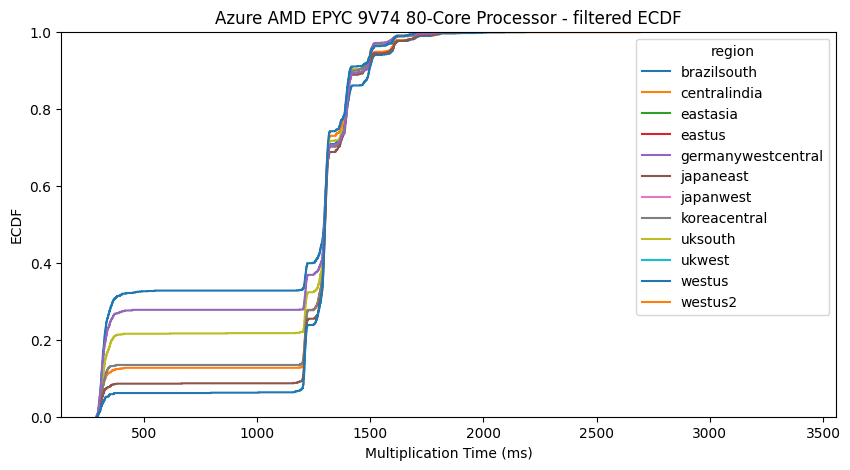

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Option B: only regions relevant to azure+512+gemm across both df_raw and df
regions = sorted(pd.concat([
    df_raw.query("provider=='azure' and memory_size_mb==512 and benchmark_type=='gemm'")["region"],
    df.query("provider=='azure' and memory_size_mb==512 and benchmark_type=='gemm'")["region"],
]).dropna().unique())

# 2) Create a fixed palette mapping
colors = sns.color_palette("tab10", n_colors=len(regions))  # change if you like
palette_map = dict(zip(regions, colors))

def plot_ecdf(data, title, outpath):
    plt.figure(figsize=(10, 5))
    sns.ecdfplot(
        data=data,
        x="multiplication_time_ms",
        hue="region",
        hue_order=regions,
        palette=palette_map,
        stat="proportion",
    )
    plt.title(title)
    plt.xlabel("Multiplication Time (ms)")
    plt.ylabel("ECDF")
    plt.savefig(outpath, bbox_inches="tight")
    plt.show()


# --- Plot 2 (filtered) ---
df_filtered_azure_2 = df[
    (df["provider"] == "azure") &
    (df["memory_size_mb"] == 512) &
    (df["benchmark_type"] == "gemm") &
    (df["cpu_type"] == "AMD EPYC 9V74")
]
print("azure filtered rows:", len(df_filtered_azure_2))
plot_ecdf(
    df_filtered_azure_2,
    "Azure AMD EPYC 9V74 80-Core Processor - filtered ECDF",
    "plots/problems/tukey/2_azure_amd_epyc_9v74_80-core_processor_filtered_ecdf.pdf",
)


/tmp/ipykernel_20111/4284374961.py:106: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regional_stats = df_inst.groupby("region").apply(compute_stats)


Saved: plots/stage_a/aws_512MB_regional_lollipop.pdf


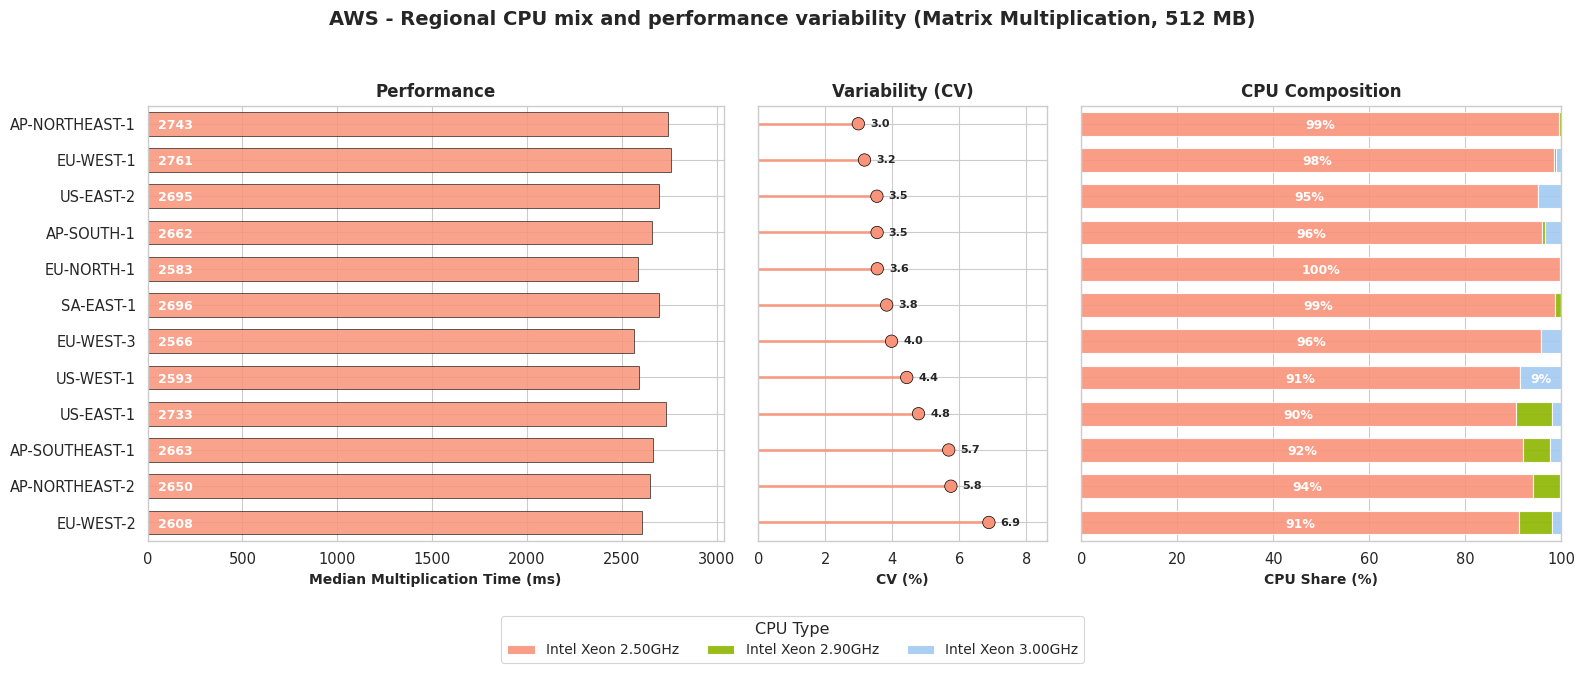

/tmp/ipykernel_20111/4284374961.py:106: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regional_stats = df_inst.groupby("region").apply(compute_stats)


Saved: plots/stage_a/alibaba_512MB_regional_lollipop.pdf


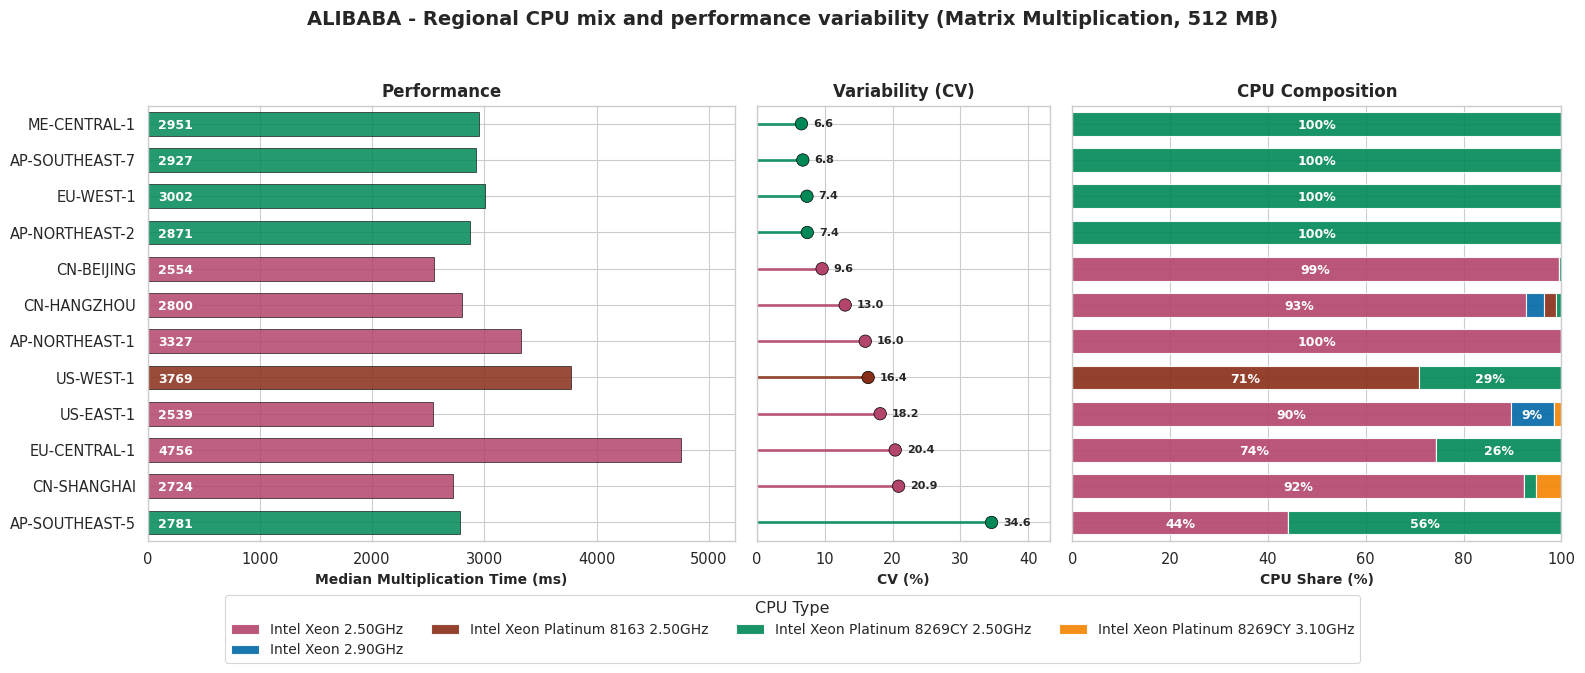

/tmp/ipykernel_20111/4284374961.py:106: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regional_stats = df_inst.groupby("region").apply(compute_stats)


Saved: plots/stage_a/gcp_512MB_regional_lollipop.pdf


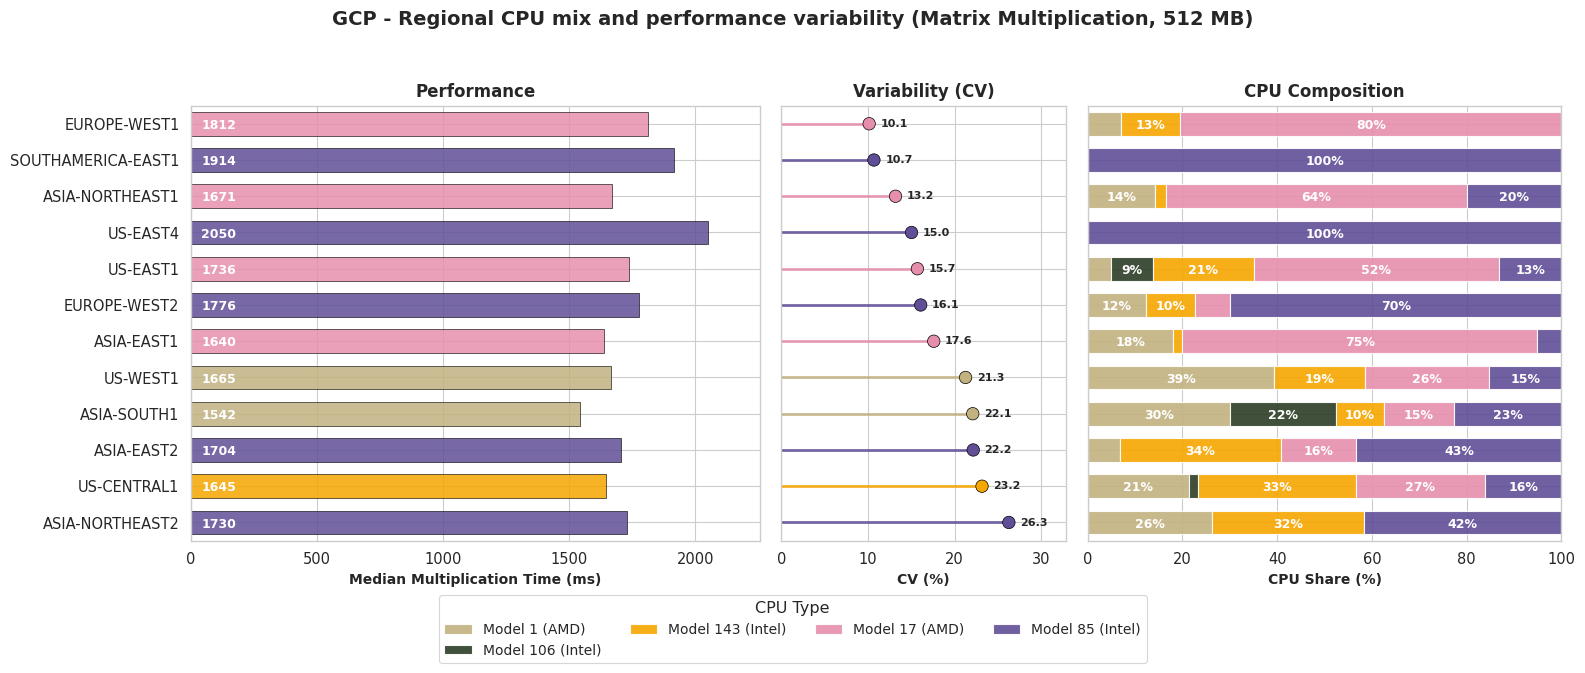

/tmp/ipykernel_20111/4284374961.py:106: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regional_stats = df_inst.groupby("region").apply(compute_stats)


Saved: plots/stage_a/azure_512MB_regional_lollipop.pdf


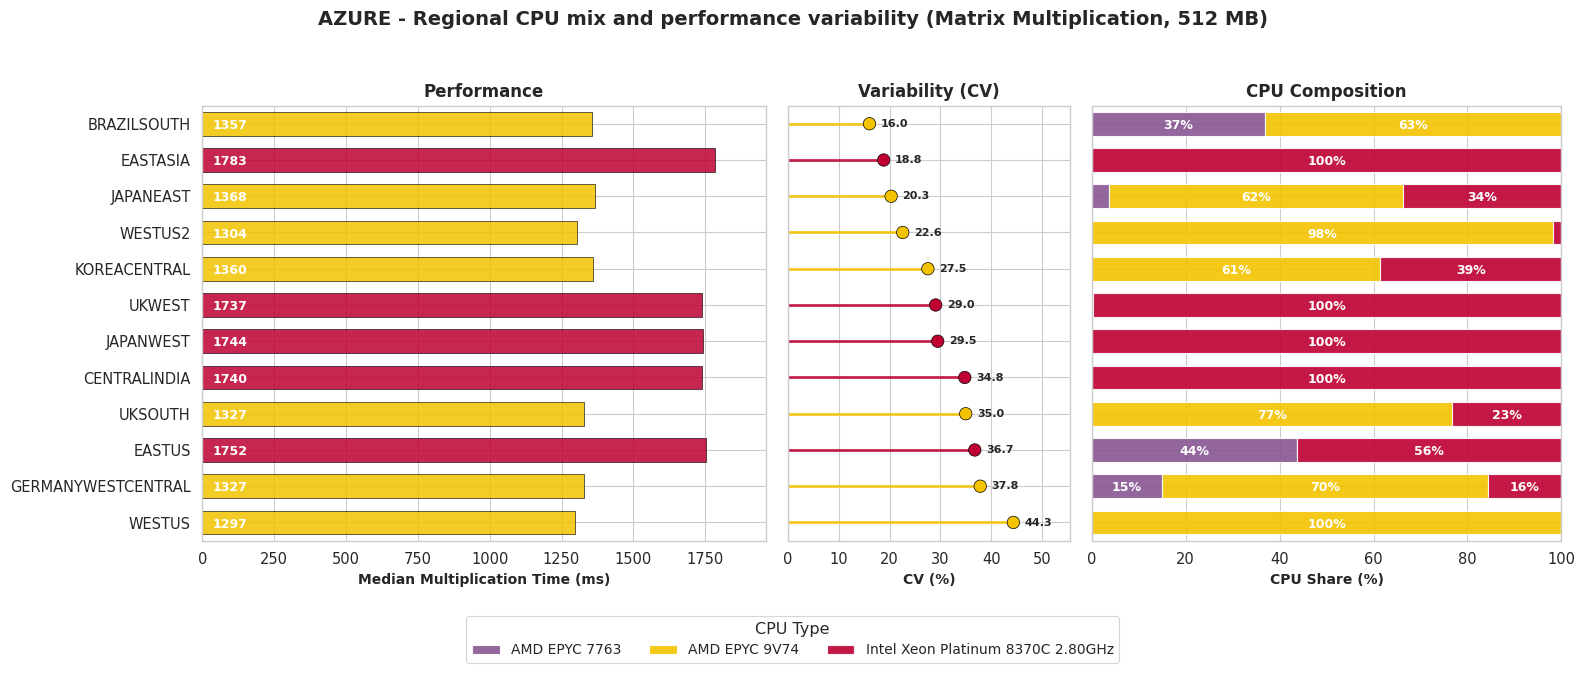

In [8]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_palette

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


def create_regional_performance_lollipop(
    df: pd.DataFrame,
    provider: str = "aws",
    memory_size: int = 512,
    benchmark_type: str = "gemm",
    # Robust default: median performance, variability via CV (or iqr/mad)
    perf_metric: str = "median",         # "mean" or "median"
    variability_metric: str = "cv",      # "sd", "cv", "iqr", "mad"
    sort_by: str = "perf",               # "perf", "sd", "cv", "iqr", "mad", "count"
    out_dir: str = "../holy/plots/StageA",
    show: bool = True,
):
    """
    Three-panel figure (expects df already filtered/cleaned):
      Left:   performance per region (default: median of instance warm means)
      Middle: variability per region (SD/CV or robust IQR/MAD of instance warm means)
      Right:  CPU composition per region (share of warm invocations)

    Bars are colored by the dominant CPU type in each region.
    """

    # --- Subset (NO extra filtering here; df should already be region-cleaned) ---
    df_base = df[
        (df["provider"] == provider)
        & (df["memory_size_mb"] == memory_size)
        & (df["benchmark_type"] == benchmark_type)
    ].copy()

    if df_base.empty:
        print(f"No data found for {provider} {memory_size}MB {benchmark_type} (after region-clean)")
        return df_base

    metric = metric_for_benchmark(benchmark_type)
    if metric not in df_base.columns:
        print(f"Metric '{metric}' not found in dataframe for benchmark '{benchmark_type}'.")
        return df_base.iloc[0:0]

    # Drop NaNs early
    df_base = df_base.dropna(subset=[metric, "region", "cpu_type", "instance_id"])
    if df_base.empty:
        print(f"No valid rows after dropping NaNs for {provider} {memory_size}MB {benchmark_type}")
        return df_base

    regions = sorted(df_base["region"].unique().tolist())
    if not regions:
        print(f"No regions found for {provider} {memory_size}MB {benchmark_type}")
        return df_base.iloc[0:0]

    # CPU palette
    all_cpu_types = sorted(df_base["cpu_type"].unique())
    cpu_colors = get_cpu_palette(all_cpu_types, provider=provider)

    # --- 1) Per-instance warm mean (unit for region stats) ---
    df_inst = (
        df_base
        .groupby(["region", "instance_id", "cpu_type"], as_index=False)[metric]
        .mean()
        .rename(columns={metric: "inst_warm_mean"})
    )

    # --- 2) Region stats on instance warm means ---
    def compute_stats(group: pd.DataFrame) -> pd.Series:
        values = group["inst_warm_mean"].dropna()
        if values.empty:
            return pd.Series({"mean": np.nan, "median": np.nan, "std": np.nan, "cv": np.nan,
                              "iqr": np.nan, "mad": np.nan, "count": 0})

        mean = values.mean()
        median = values.median()
        std = values.std(ddof=1)

        # Standard CV relative to mean
        cv = (std / mean * 100.0) if (mean is not None and mean > 0) else np.nan

        # Robust variability measures
        q1 = values.quantile(0.25)
        q3 = values.quantile(0.75)
        iqr = q3 - q1

        mad = np.median(np.abs(values - median))  # unscaled MAD (fine for comparisons)

        return pd.Series(
            {
                "mean": mean,
                "median": median,
                "std": std,
                "cv": cv,
                "iqr": iqr,
                "mad": mad,
                "count": len(values),
            }
        )

    regional_stats = df_inst.groupby("region").apply(compute_stats)

    # Remove regions with no instances
    regional_stats = regional_stats.dropna(subset=["median", "mean"], how="all")
    if regional_stats.empty:
        print(f"No regional stats after aggregation for {provider} {memory_size}MB {benchmark_type}")
        return df_base.iloc[0:0]

    # --- Choose performance column ---
    perf_col = "median" if perf_metric.lower() == "median" else "mean"

    # --- Sorting ---
    if sort_by == "perf":
        # lower is better for runtimes; adjust if you have throughput-like metrics
        regions_sorted = regional_stats.sort_values(perf_col, ascending=True).index.tolist()
    elif sort_by in {"cv", "std", "iqr", "mad", "count"}:
        regions_sorted = regional_stats.sort_values(sort_by, ascending=False).index.tolist()
    else:
        regions_sorted = regional_stats.sort_values(perf_col, ascending=True).index.tolist()

    regional_stats = regional_stats.reindex(regions_sorted)

    # --- 3) CPU composition per region (based on warm invocations) ---
    cpu_dist_df = (
        df_base
        .groupby(["region", "cpu_type"])
        .size()
        .rename("n")
        .reset_index()
    )
    cpu_dist_df["pct"] = cpu_dist_df.groupby("region")["n"].transform(lambda x: x / x.sum() * 100.0)

    cpu_dist_pivot = (
        cpu_dist_df
        .pivot(index="region", columns="cpu_type", values="pct")
        .fillna(0.0)
        .reindex(regions_sorted)
    )

    # Dominant CPU per region (for coloring the perf bars)
    dominant_cpu = (
        df_base.groupby(["region", "cpu_type"]).size()
        .rename("n").reset_index()
        .sort_values(["region", "n"], ascending=[True, False])
        .drop_duplicates("region")
        .set_index("region")["cpu_type"]
        .to_dict()
    )

    # --- Figure layout ---
    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3,
        figsize=(16, max(6, len(regions_sorted) * 0.55)),
        gridspec_kw={"width_ratios": [1.2, 0.6, 1]},
    )

    y_pos = np.arange(len(regions_sorted))

    # === LEFT: performance (mean/median) ===
    perf_values = regional_stats[perf_col].values
    bar_colors = [cpu_colors.get(dominant_cpu.get(r, "Unknown"), "#7f8c8d") for r in regions_sorted]

    bars = ax1.barh(
        y_pos,
        perf_values,
        color=bar_colors,
        alpha=0.85,
        edgecolor="black",
        linewidth=0.5,
        height=0.65,
    )

    x_max = np.nanmax(perf_values) if len(perf_values) else 1.0
    x_max = x_max if np.isfinite(x_max) and x_max > 0 else 1.0
    x_label_pos = max(x_max * 0.02, 1e-9)

    for bar, val in zip(bars, perf_values):
        if pd.isna(val):
            continue
        y = bar.get_y() + bar.get_height() / 2
        ax1.text(
            x_label_pos,
            y,
            f"{val:.0f}",
            ha="left",
            va="center_baseline",
            color="white",
            fontweight="bold",
            fontsize=9,
        )

    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([r.upper() for r in regions_sorted])
    xlabel = "Median" if perf_col == "median" else "Mean"
    ax1.set_xlabel(f"{xlabel} Multiplication Time (ms)", fontweight="bold", fontsize=10)
    ax1.set_title("Performance", fontweight="bold", fontsize=12)
    ax1.set_ylim(-0.5, len(regions_sorted) - 0.5)
    ax1.set_xlim(0, x_max * 1.10)

    # === MIDDLE: variability lollipop ===
    vm = variability_metric.lower()
    if vm == "cv":
        var_values = regional_stats["cv"].values
        var_label = "CV (%)"
        var_title = "Variability (CV)"
    elif vm == "sd":
        var_values = regional_stats["std"].values
        var_label = "Std Dev (ms)"
        var_title = "Variability (SD)"
    elif vm == "iqr":
        var_values = regional_stats["iqr"].values
        var_label = "IQR (ms)"
        var_title = "Variability (IQR)"
    elif vm == "mad":
        var_values = regional_stats["mad"].values
        var_label = "MAD (ms)"
        var_title = "Variability (MAD)"
    else:
        raise ValueError("variability_metric must be one of: 'cv', 'sd', 'iqr', 'mad'")

    var_plot = np.where(np.isnan(var_values), 0.0, var_values)
    vmax = np.nanmax(var_plot) if len(var_plot) else 1.0
    vmax = vmax if np.isfinite(vmax) and vmax > 0 else 1.0

    for i, (y, val) in enumerate(zip(y_pos, var_plot)):
        ax2.hlines(y=y, xmin=0, xmax=val, color=bar_colors[i], linewidth=2, alpha=0.85)

    ax2.scatter(var_plot, y_pos, color=bar_colors, s=80, zorder=5, edgecolor="black", linewidth=0.5)

    for y, raw_val, val in zip(y_pos, var_values, var_plot):
        if pd.isna(raw_val):
            continue
        ax2.text(
            val + (vmax * 0.05),
            y,
            f"{raw_val:.1f}",
            ha="left",
            va="center",
            fontweight="bold",
            fontsize=8,
        )

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([])
    ax2.set_xlabel(var_label, fontweight="bold", fontsize=10)
    ax2.set_title(var_title, fontweight="bold", fontsize=12)
    ax2.set_ylim(-0.5, len(regions_sorted) - 0.5)
    ax2.set_xlim(0, vmax * 1.25)

    # === RIGHT: CPU composition stacked bars ===
    left_positions = np.zeros(len(regions_sorted))

    for cpu_type in all_cpu_types:
        if cpu_type not in cpu_dist_pivot.columns:
            continue

        values = cpu_dist_pivot[cpu_type].values
        cpu_label = shorten_cpu_name(cpu_type)

        bars_stack = ax3.barh(
            y_pos,
            values,
            left=left_positions,
            label=cpu_label,
            color=cpu_colors.get(cpu_type, "#7f8c8d"),
            alpha=0.90,
            edgecolor="white",
            height=0.65,
        )

        for i, (bar, v) in enumerate(zip(bars_stack, values)):
            if v > 8:
                ax3.text(
                    left_positions[i] + v / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f"{v:.0f}%",
                    ha="center",
                    va="center_baseline",
                    fontweight="bold",
                    fontsize=9,
                    color="white",
                )

        left_positions += values

    ax3.set_yticks(y_pos)
    ax3.set_yticklabels([])
    ax3.set_xlabel("CPU Share (%)", fontweight="bold", fontsize=10)
    ax3.set_title("CPU Composition", fontweight="bold", fontsize=12)
    ax3.set_xlim(0, 100)
    ax3.set_ylim(-0.5, len(regions_sorted) - 0.5)

    # Legend below figure
    handles, labels = ax3.get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="CPU Type",
        loc="lower center",
        bbox_to_anchor=(0.5, -0.02),
        ncol=min(4, len(handles)) if handles else 1,
        fontsize=10,
    )

    fig.suptitle(
        f"{provider.upper()} - Regional CPU mix and performance variability (Matrix Multiplication, {memory_size} MB)",
        fontsize=14,
        fontweight="bold",
        y=0.98,
    )

    plt.tight_layout(rect=[0, 0.08, 1, 0.95])

    # Save
    os.makedirs(out_dir, exist_ok=True)
    filename = f"{out_dir}/{provider}_{memory_size}MB_regional_lollipop.pdf"
    plt.savefig(filename, bbox_inches="tight", dpi=150)
    print(f"Saved: {filename}")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return df_base


# Example usage (df is expected to be the region-cleaned df)
for provider, mem in [("aws", 512), ("alibaba", 512), ("gcp", 512), ("azure", 512)]:
    create_regional_performance_lollipop(
        df,
        provider=provider,
        memory_size=mem,
        benchmark_type="gemm",
        perf_metric="median",          # <-- robust performance summary
        variability_metric="cv",      # <-- robust variability (try "cv" if you prefer)
        sort_by="cv",
        out_dir="plots/stage_a",
        show=True,
    )


Saved: plots/stage_a/cpu_consistency_ecdf_raw_consistent_colors.pdf


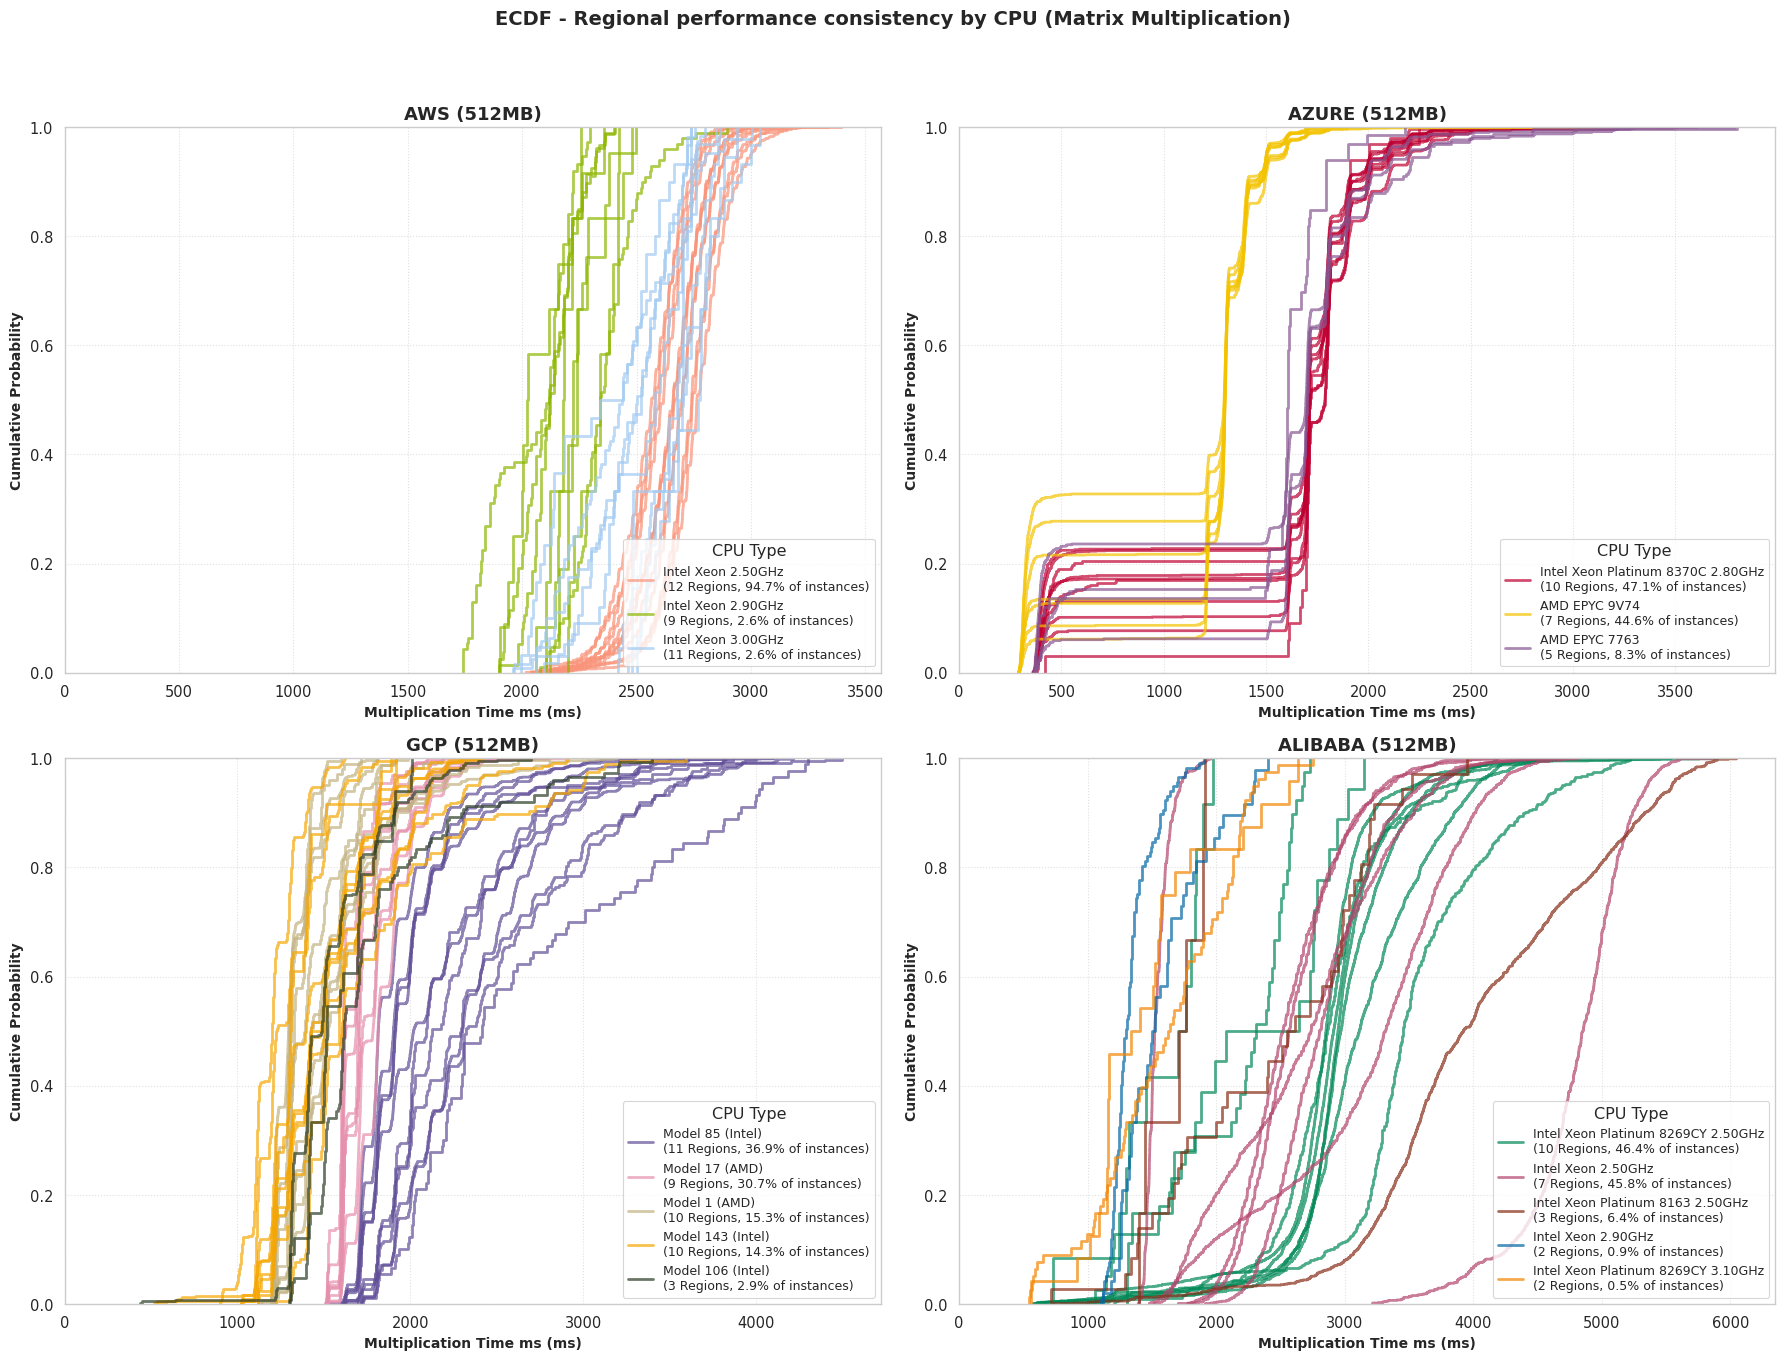

In [12]:
import os
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_palette

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


def select_top_cpus_raw(df_prov: pd.DataFrame, top_n: int = 3, min_instances: int = 20) -> list[str]:
    """
    Select top CPUs by number of unique instances (stable), using raw (warm) rows.
    """
    if df_prov.empty:
        return []

    cpu_stats = (
        df_prov.groupby("cpu_type")["instance_id"]
        .nunique()
        .rename("n_instances")
        .to_frame()
    )
    cpu_stats = cpu_stats[cpu_stats["n_instances"] >= min_instances]

    return (
        cpu_stats.sort_values("n_instances", ascending=False)
        .head(top_n)
        .index
        .tolist()
    )


def plot_cpu_consistency_ecdf_raw(
    df: pd.DataFrame,
    providers: list[str] | None = None,
    memory_configs: dict[str, int] | None = None,
    benchmark_type: str = "gemm",
    top_n: int = 3,
    min_instances: int = 20,
    out_dir: str = "../holy/plots/StageA",
    show: bool = True,
):
    """
    ECDF plots (RAW): each line is one CPU type in one region, using ALL warm invocation values.

    - Expects df already region-cleaned (CPU normalized, warm-only, complete groups, Tukey done per region).
    - Does NOT call filter_cpu_data().
    - Does NOT aggregate per instance (no mean/median).
    - Uses get_cpu_palette(...) for consistent CPU colors (same style as your 3-panel plot).
    """

    if providers is None:
        providers = ["aws", "azure", "gcp", "alibaba"]
    if memory_configs is None:
        memory_configs = {p: 512 for p in providers}

    metric = metric_for_benchmark(benchmark_type)
    metric_label = metric.replace("_", " ").title().replace("Ms", "ms")

    n = len(providers)
    ncols = 2
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 7 * nrows))
    axes = np.array(axes).reshape(-1)

    for idx, provider in enumerate(providers):
        ax = axes[idx]
        memory_size = memory_configs.get(provider, 512)

        df_prov = df[
            (df["provider"] == provider)
            & (df["memory_size_mb"] == memory_size)
            & (df["benchmark_type"] == benchmark_type)
        ].copy()

        if df_prov.empty or metric not in df_prov.columns:
            ax.text(0.5, 0.5, f"No Data: {provider.upper()}", ha="center", transform=ax.transAxes)
            ax.axis("off")
            continue

        df_prov = df_prov.dropna(subset=["cpu_type", "region", "instance_id", metric])
        if df_prov.empty:
            ax.text(0.5, 0.5, f"No Valid Rows: {provider.upper()}", ha="center", transform=ax.transAxes)
            ax.axis("off")
            continue

        top_cpus = select_top_cpus_raw(df_prov, top_n=top_n, min_instances=min_instances)
        if not top_cpus:
            ax.text(0.5, 0.5, "Insufficient CPU Samples", ha="center", transform=ax.transAxes)
            ax.axis("off")
            continue

        # consistent CPU colors (like your 3-panel plot)
        cpu_colors = get_cpu_palette(top_cpus, provider=provider)

        # axis limits
        xmax = df_prov.loc[df_prov["cpu_type"].isin(top_cpus), metric].max()
        ax.set_xlim(0, xmax * 1.05 if pd.notna(xmax) and xmax > 0 else None)
        ax.set_ylim(0, 1)

        lines_for_legend = []
        labels_for_legend = []
        total_instances = df_prov["instance_id"].nunique()

        for cpu_name in top_cpus:
            cpu_data = df_prov[df_prov["cpu_type"] == cpu_name]
            regions = sorted(cpu_data["region"].dropna().unique())

            cpu_instances = cpu_data["instance_id"].nunique()
            share = (cpu_instances / total_instances * 100.0) if total_instances else 0.0

            cpu_clean = shorten_cpu_name(cpu_name)
            color = cpu_colors.get(cpu_name, "#7f8c8d")

            added_to_legend = False

            for region in regions:
                r_vals = (
                    cpu_data.loc[cpu_data["region"] == region, metric]
                    .dropna()
                    .sort_values()
                    .values
                )
                if len(r_vals) < 5:
                    continue

                # ECDF step plot starting at y=0
                y_ecdf = np.arange(1, len(r_vals) + 1) / len(r_vals)
                x_step = np.concatenate(([r_vals[0]], r_vals))
                y_step = np.concatenate(([0.0], y_ecdf))

                line = ax.step(x_step, y_step, where="post", color=color, alpha=0.7, linewidth=2)[0]

                if not added_to_legend:
                    lines_for_legend.append(line)
                    labels_for_legend.append(f"{cpu_clean}\n({len(regions)} Regions, {share:.1f}% of instances)")
                    added_to_legend = True

        if lines_for_legend:
            ax.legend(
                lines_for_legend,
                labels_for_legend,
                title="CPU Type",
                fontsize=9,
                loc="lower right",
            )

        ax.set_title(f"{provider.upper()} ({memory_size}MB)", fontweight="bold", fontsize=13)
        ax.set_xlabel(f"{metric_label} (ms)", fontweight="bold", fontsize=10)
        ax.set_ylabel("Cumulative Probability", fontweight="bold", fontsize=10)
        ax.grid(True, linestyle=":", alpha=0.6)

    for j in range(n, len(axes)):
        axes[j].axis("off")

    fig.suptitle(
        "ECDF - Regional performance consistency by CPU (Matrix Multiplication)",
        fontsize=14,
        fontweight="bold",
        y=0.99,
    )
    plt.tight_layout(rect=[0, 0.02, 1, 0.96])

    os.makedirs(out_dir, exist_ok=True)
    out_file = f"{out_dir}/cpu_consistency_ecdf_raw_consistent_colors.pdf"
    plt.savefig(out_file, bbox_inches="tight")
    print(f"Saved: {out_file}")

    if show:
        plt.show()
    else:
        plt.close(fig)


# Example usage (df is the region-cleaned df)
mixed_memory_config = {"aws": 512, "gcp": 512, "alibaba": 512, "azure": 512}

plot_cpu_consistency_ecdf_raw(
    df,
    providers=["aws", "azure", "gcp", "alibaba"],
    memory_configs=mixed_memory_config,
    benchmark_type="gemm",
    top_n=6,
    min_instances=5,
    out_dir="plots/stage_a",
)
